# Drug Induced Liver Injury pyramidal prediction protocol:
### Combining Molecular Descriptors and Clinical Adverse effects to develop Adverse effects models for predicting DILI.

In [ ]:
## Index:
'''
    1. Sider Dataset with Hepatobiliry disorders Adverse Effects (AEs) analysis:
         1.1. Distribution of AEs
         1.2. Cluster map with AEs
         1.3. Heat map of correlation matrix among AEs

    2. Building and evaluating models for each DILI endpoints 
         2.1. Creating endpoint separate files to create Flame models
         2.2. Building STEP
             2.2.1.  Removing endpoints if previously built
             2.2.2.  Building and evaluation internal perfomance

     3. Evaluating models for each DILI endpoints
         3.1. Prediction and consensus functions
         3.2. Reading and adding information to performance models Dataframe
         3.3. External Validation Sets
             3.3.1. LTKB Dataset
                 3.3.1.1. Loading and filtering
                 3.3.1.2. Computing predictions
             3.3.2. PfizerDataset
                 3.3.2.1. Loading
                 3.3.2.2. Computing predictions
             3.3.3. Obrien Dataset
                 3.3.3.1. Loading
                 3.3.3.2. Computing predictions
             3.3.4. Mulliner Dataset
                 3.3.4.1. Loading and filtering
                 3.3.4.2. Computing predictions
             3.3.5. Combine (ltkb, obrain, pfizer and mulliner) Dataset
                 3.3.5.1. Loading and filtering
                 3.3.5.2. Computing predictions

    4. PLS variable importance analysis
         4.1. Functions
         4.2. LTKB
         4.3. Pfizer
         4.4. Obrien
         4.5. Mulliner
         4.6. All Combined
         4.7. Comparision PLS coefficients among all Sources: ALL, LTKB, PFIZER and OBRIEN

    5.  Combining Predictions
         5.1. Prediction  and consensus functions
         5.2. LTKB Dataset
         5.3. PfizerDataset
         5.4. Obrien Dataset
         5.5. Mulliner Dataset
         5.6. Combine (ltkb, obrain, pfizer and mulliner) Dataset
'''

# Importing libraries

In [1]:
import pandas as pd
from rdkit.Chem import PandasTools as pt
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks")

from rdkit.Chem import AllChem
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.cross_decomposition import PLSRegression

In [2]:
# Import Flame and RDKit libraries

from flame.build import Build
from flame.predict import Predict
from flame.manage import *
from rdkit.Chem import PandasTools as pt
pd.options.display.max_columns = None

%config Completer.use_jedi=False

In [3]:
def checkAtomsCoordinates(m):
    '''
        Function to check if a molecule contains zero coordinates in all atoms. 
        Then this molecule must be eliminated.
        Returns True if molecules is OK and False if molecule contains zero coordinates.
        
        Example:
            # Load  test set to a frame
            pfizersdf = 'validations_sets/pfizer-3Dprot-info.sdf'
            pfizer_val = pt.LoadSDF(pfizersdf, molColName='mol3DProt')
            ## Checking if molecule contains only ZERO coordinates, then remove that molecules from dataset
            pfizer_val['check_coordinates'] = [checkAtomsCoordinates(x) for x in pfizer_val.mol3DProt]
            pfizer_val_eliminated_mols = pfizer_val[pfizer_val.check_coordinates == False]
            pfizer_val = pfizer_val[pfizer_val.check_coordinates == True]
            pfizer_val.drop(columns=['check_coordinates'], inplace=True)
            print('final pfizer_val ltkbing set:', pfizer_val.shape[0])
            print('Sider pfizer_val elimnated:', pfizer_val_eliminated_mols.shape[0])

            ## Writing SD file of ltkb filtered dataframe
            pfizersdf = '../10-combination/2-ltkb/1-notmatch-testset/morganFP/ltkb_dissim_mfp_curated.sdf'

            pt.WriteSDF(pfizer_val, pfizersdf, properties = list(pfizer_val.columns), molColName='mol3DProt')
    '''
    conf = m.GetConformer()
    position = []
    for i in range(conf.GetNumAtoms()):
        pos = conf.GetAtomPosition(i)
        position.append([pos.x, pos.y, pos.z])
    position = np.array(position)
    if not np.any(position):
        return(False)
    else:
        return(True)

In [4]:
def createDir(vpath, dirname):
    '''
    This functions checks if dirname exists in path given, 
    if does not exists, then it will be created. 
    
    e.g. 
    
        vpath = os.getcwd() ## current directory path
        dir2Dname = '2-2Dcoord' ### directory name to be created

        createDir(vpath, dir2Dname)
    '''
    directory = vpath+'/'+dirname

    if not os.path.exists(directory):
        os.makedirs(directory)
        print (dirname + ' is created')
    else: 
        print(dirname + ' already exists')

# 1. Sider Dataset with Hepatobiliry disorders Adverse Effects (AEs) analysis

In [5]:
# Read the data with training set, sheet 0.
# Loading training set: SIDER dataset with 4th level Hepatobiliary disorders adverse effects
train = pd.read_pickle("../../../data/1-clinical/9-sider-frec/pivot_sider_pi_4thlevel_HPTD.pkl")

In [6]:
# Checking if any molecule needs to be eliminated
train['check_coordinates'] = [checkAtomsCoordinates(x) for x in train.mol3DProt]
train_eliminated_mols = train[train.check_coordinates != True]
train = train[train.check_coordinates == True]
train.drop(columns=['check_coordinates'], inplace=True)
print('final Sider training set:', train.shape[0])
print('Sider molecules elimnated:', train_eliminated_mols.shape[0])

final Sider training set: 937
Sider molecules elimnated: 0


,parent_nonstd_inkey,1st_level,2nd_level,3rd_level,4th_level,InChI,MedDRA_concept_type,UMLSID_LABEL,UMLSID_medDRA,adverse_effect,atc_codes,atc_names,clust1_description,clust2_description,clust3_description,clust4_description,cluster1,cluster2,cluster3,cluster4,parent_nonstd_inchi,parent_smiles,parent_std_inchi,parent_std_inkey,siderID,siderID_FLAT,siderID_STEREO,sider_DILI_class,sider_names,std_smiles,mol3DProt,Hepatitis,Jaundice,Hepatobiliary disease,Hepatic failure,Hepatic function abnormal,Hepatocellular injury,Jaundice cholestatic,Hyperbilirubinaemia,Liver injury,Cholestasis,Hepatotoxicity,Hepatomegaly,Liver disorder,Hepatic necrosis,Cholelithiasis,Cholecystitis,Foetor hepaticus,Hepatitis cholestatic,Ascites
0,AAKJLRGGTJKAMG-LNNLXFCONA-N,Hepatobiliary disorders,"Hepatic and hepatobiliary disorders, Hepatobiliary neoplasms","Malignant hepatobiliary neoplasms, Hepatobiliary signs and symptoms, Hepatocellular damage and hepatitis NEC, Hepatic failure and associated disorders, Hepatic and hepatobiliary disorders NEC","Hepatic cancer metastatic, Hepatobiliary disease, Hepatocellular injury, Liver disorder, Hepatitis, Metastases to liver, Hepatotoxicity, Hepatorenal syndrome, Hepatic failure, Foetor hepaticus","InChI=1/C22H23N3O4.ClH/c1-4-16-6-5-7-17(12-16)25-22-18-13-20(28-10-8-26-2)21(29-11-9-27-3)14-19(18)23-15-24-22;/h1,5-7,12-15H,8-11H2,2-3H3,(H,23,24,25);1H/fC22H23N3O4.Cl.H/h25H;1h;/q;-1;+1",PT,"C0085605, C0948807, C0023895, C0267792, C0235378, C0019212, C0494165, C0019158","C0085605, C0023895, C0267792, C0235378, C0239571, C0856554, C0019212, C0494165, C0151763, C0019158","Hepatic cancer metastatic, Hepatobiliary disease, Hepatocellular injury, Liver disorder, Hepatitis, Metastases to liver, Hepatotoxicity, Hepatorenal syndrome, Hepatic failure, Foetor hepaticus",L01XE03,erlotinib,ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS,ANTINEOPLASTIC AGENTS,OTHER ANTINEOPLASTIC AGENTS,Protein kinase inhibitors,L,L01,L01X,L01XE,"InChI=1/C22H23N3O4/c1-4-16-6-5-7-17(12-16)25-22-18-13-20(28-10-8-26-2)21(29-11-9-27-3)14-19(18)23-15-24-22/h1,5-7,12-15H,8-11H2,2-3H3,(H,23,24,25)/f/h25H",[H]C#Cc1c([H])c([H])c([H])c(N([H])c2nc([H])nc3c([H])c(OC([H])([H])C([H])([H])OC([H])([H])[H])c(OC([H])([H])C([H])([H])OC([H])([H])[H])c([H])c23)c1[H],"InChI=1S/C22H23N3O4/c1-4-16-6-5-7-17(12-16)25-22-18-13-20(28-10-8-26-2)21(29-11-9-27-3)14-19(18)23-15-24-22/h1,5-7,12-15H,8-11H2,2-3H3,(H,23,24,25)",AAKJLRGGTJKAMG-UHFFFAOYSA-N,CID100176870,CID100176870,CID000176870,1,erlotinib,COCCOc1cc2ncnc(Nc3cccc(c3)C#C)c2cc1OCCOC,"<img src="""" alt=""Mol""/>",1,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0

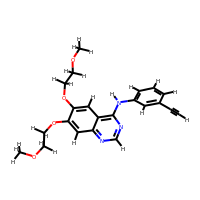

In [7]:
train.head(1)

In [8]:
## Renaming adverse effect columns errasing spaces:
keepcols = train.loc[:,:'Hepatitis'].columns[:-1] ## columns to keep without being renamed
aecols = train.loc[:,'Hepatitis':].columns ## adverse effect columns
aecols = [x.replace(" ", "_") for x in aecols]
train.columns = list(keepcols)+list(aecols)

In [9]:
siderdf = pt.LoadSDF('training_AEs_sider.sdf', molColName='mol3DProt')
siderdf = siderdf[train.columns]

,parent_nonstd_inkey,1st_level,2nd_level,3rd_level,4th_level,InChI,MedDRA_concept_type,UMLSID_LABEL,UMLSID_medDRA,adverse_effect,atc_codes,atc_names,clust1_description,clust2_description,clust3_description,clust4_description,cluster1,cluster2,cluster3,cluster4,parent_nonstd_inchi,parent_smiles,parent_std_inchi,parent_std_inkey,siderID,siderID_FLAT,siderID_STEREO,sider_DILI_class,sider_names,std_smiles,mol3DProt,Hepatitis,Jaundice,Hepatobiliary_disease,Hepatic_failure,Hepatic_function_abnormal,Hepatocellular_injury,Jaundice_cholestatic,Hyperbilirubinaemia,Liver_injury,Cholestasis,Hepatotoxicity,Hepatomegaly,Liver_disorder,Hepatic_necrosis,Cholelithiasis,Cholecystitis,Foetor_hepaticus,Hepatitis_cholestatic,Ascites
0,AAKJLRGGTJKAMG-LNNLXFCONA-N,Hepatobiliary disorders,"Hepatic and hepatobiliary disorders, Hepatobiliary neoplasms","Malignant hepatobiliary neoplasms, Hepatobiliary signs and symptoms, Hepatocellular damage and hepatitis NEC, Hepatic failure and associated disorders, Hepatic and hepatobiliary disorders NEC","Hepatic cancer metastatic, Hepatobiliary disease, Hepatocellular injury, Liver disorder, Hepatitis, Metastases to liver, Hepatotoxicity, Hepatorenal syndrome, Hepatic failure, Foetor hepaticus","InChI=1/C22H23N3O4.ClH/c1-4-16-6-5-7-17(12-16)25-22-18-13-20(28-10-8-26-2)21(29-11-9-27-3)14-19(18)23-15-24-22;/h1,5-7,12-15H,8-11H2,2-3H3,(H,23,24,25);1H/fC22H23N3O4.Cl.H/h25H;1h;/q;-1;+1",PT,"C0085605, C0948807, C0023895, C0267792, C0235378, C0019212, C0494165, C0019158","C0085605, C0023895, C0267792, C0235378, C0239571, C0856554, C0019212, C0494165, C0151763, C0019158","Hepatic cancer metastatic, Hepatobiliary disease, Hepatocellular injury, Liver disorder, Hepatitis, Metastases to liver, Hepatotoxicity, Hepatorenal syndrome, Hepatic failure, Foetor hepaticus",L01XE03,erlotinib,ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS,ANTINEOPLASTIC AGENTS,OTHER ANTINEOPLASTIC AGENTS,Protein kinase inhibitors,L,L01,L01X,L01XE,"InChI=1/C22H23N3O4/c1-4-16-6-5-7-17(12-16)25-22-18-13-20(28-10-8-26-2)21(29-11-9-27-3)14-19(18)23-15-24-22/h1,5-7,12-15H,8-11H2,2-3H3,(H,23,24,25)/f/h25H",[H]C#Cc1c([H])c([H])c([H])c(N([H])c2nc([H])nc3c([H])c(OC([H])([H])C([H])([H])OC([H])([H])[H])c(OC([H])([H])C([H])([H])OC([H])([H])[H])c([H])c23)c1[H],"InChI=1S/C22H23N3O4/c1-4-16-6-5-7-17(12-16)25-22-18-13-20(28-10-8-26-2)21(29-11-9-27-3)14-19(18)23-15-24-22/h1,5-7,12-15H,8-11H2,2-3H3,(H,23,24,25)",AAKJLRGGTJKAMG-UHFFFAOYSA-N,CID100176870,CID100176870,CID000176870,1,erlotinib,COCCOc1cc2ncnc(Nc3cccc(c3)C#C)c2cc1OCCOC,,1,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0
1,AAOVKJBEBIDNHE-UHFFFAOYNA-N,Hepatobiliary disorders,Hepatic and hepatobiliary disorders,"Hepatic and hepatobiliary disorders NEC, Cholestasis and jaundice, Hepatic enzymes and function abnormalities","Hepatobiliary disease, Hepatic function abnormal, Jaundice","InChI=1/C16H13ClN2O/c1-19-14-8-7-12(17)9-13(14)16(18-10-15(19)20)11-5-3-2-4-6-11/h2-9H,10H2,1H3",PT,"C0267792, C0022346, C0086565","C0267792, C0022346, C0086565","Hepatobiliary disease, Hepatic function abnormal, Jaundice",N05BA01,diazepam,NERVOUS SYSTEM,PSYCHOLEPTICS,ANXIOLYTICS,Benzodiazepine derivatives,N,N05,N05B,N05BA,"InChI=1/C16H13ClN2O/c1-19-14-8-7-12(17)9-13(14)16(18-10-15(19)20)11-5-3-2-4-6-11/h2-9H,10H2,1H3",[H]c1c([H])c([H])c(C2=NC([H])([H])C(=O)N(C([H])([H])[H])c3c([H])c([H])c(Cl)c([H])c32)c([H])c1[H],"InChI=1S/C16H13ClN2O/c1-19-14-8-7-12(17)9-13(14)16(18-10-15(19)20)11-5-3-2-4-6-11/h2-9H,10H2,1H3",AAOVKJBEBIDNHE-UHFFFAOYSA-N,CID100003016,CID100003016,CID000003016,1,diazepam,CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21,,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0

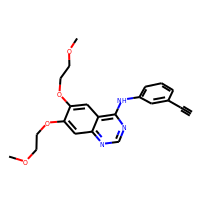
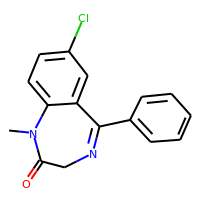

In [10]:
siderdf.head(2)

## 1.1. Distribution of adverse effects

figures already exists


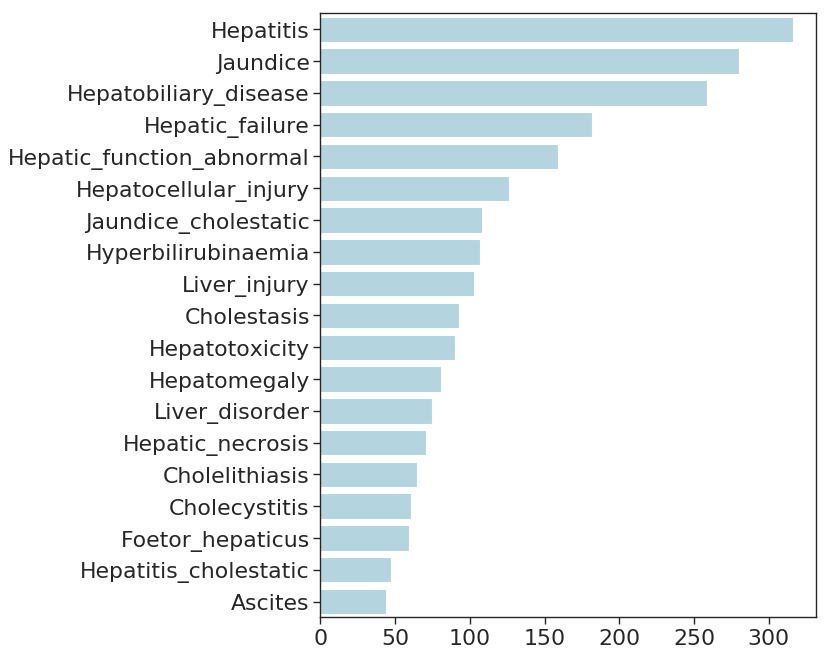

In [11]:
# Plot the distribution of side effects in the data. 
x = []
y = []
for col in aecols:
    x.append(siderdf[col].value_counts()[1])
    y.append(col)
sns.set(font_scale=1.8, font='Calibri', palette='bright')
sns.set_style('ticks') ## to get white background and ticks
fig = plt.figure(figsize=(8, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.barplot(x, y, color='lightblue')
createDir(os.getcwd(),'figures')
fig.savefig("figures/compounds_per_AE_distribution.png", bbox_inches="tight")

### Figure 1.1. Explanation
This bar plot shows the adverse effects distribution among the whole compounds present in SIDER applying MedDRA ontology (Hepatobiliary Disorders) and a filter of getting only Adverse effects containing more than 40 adverse effects.  

## 1.2. Cluster map with adverse effects

In [12]:
# Get a subframe with only side effect columns
subframe = siderdf[aecols]
subframe = subframe.astype(int)

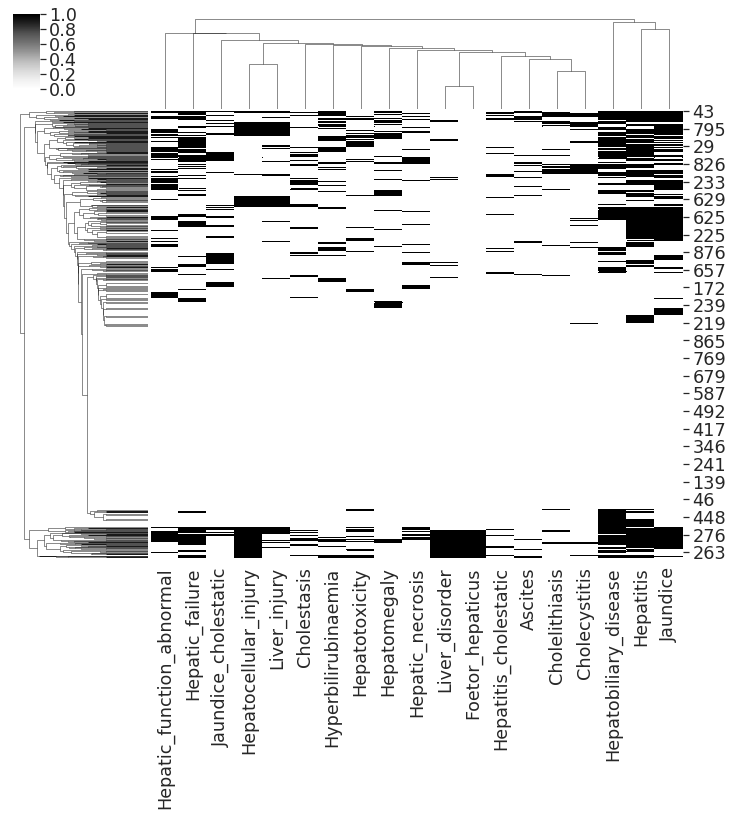

In [13]:
# Plot a clustermap of side effects.
# fig = plt.figure(figsize=(11.7, 8.27), dpi= 80, facecolor='w', edgecolor='k')
sns.set(font_scale=1.6)
cluster_map = sns.clustermap(subframe, figsize=(12, 10), cmap='Greys')
cluster_map.savefig("figures/clustermap_AEs_distribution.png", bbox_inches="tight")

### Figure 1.2. Explanation
This clustermap plot is showing the adverse effects distribution among the whole compounds present in SIDER applying MedDRA ontology (Hepatobiliary Disorders) and a filter of getting only Adverse effects containing more than 40 adverse effects. The hierachical clustering (dendrogram) is not giving so much information. On the other hand, the heat map is giving us infomation about the balance between adverse effect presence or not, where blank and light brown colors mean not present and present respectively. This dataset is not very well equilibrated.

## 1.3. Heat map of correlation matrix among Adverse effects

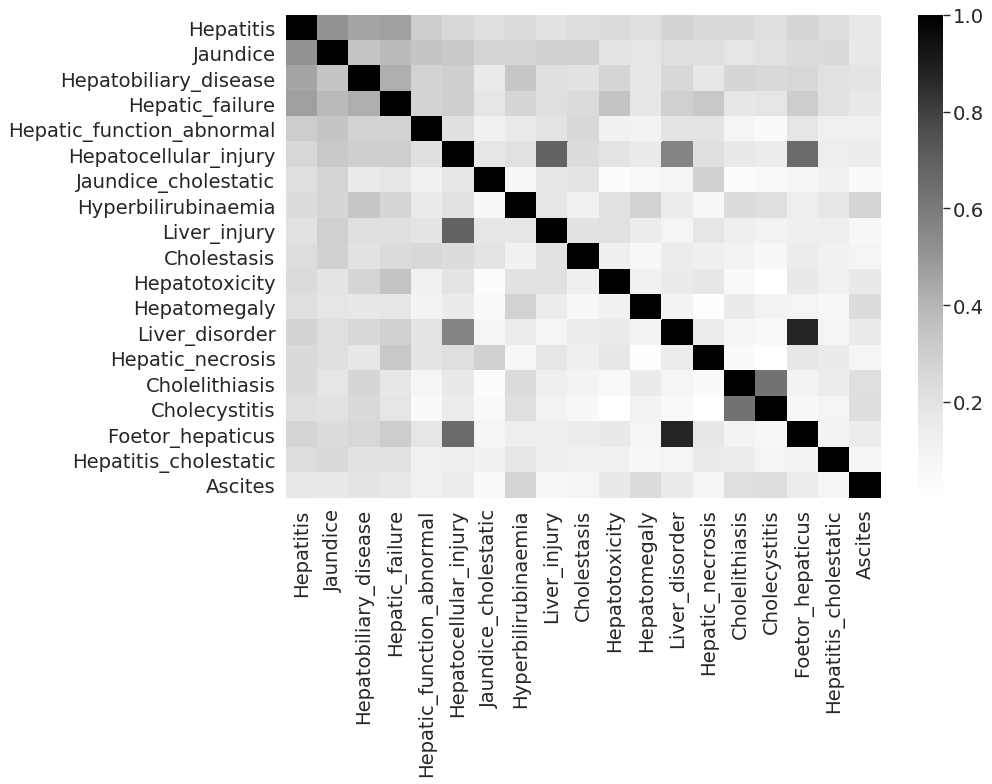

In [14]:
# Get the correlation matrix among side effects and plot it in a 
# heatmap
correlation = subframe.corr()
sns.set(font_scale=1.6)
fig = plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
heatmap = sns.heatmap(correlation, cmap='Greys')
fig.savefig("figures/heatmap_AEs_distribution.png", bbox_inches="tight")
# heatmap = ax.set_xlabel('Adverse Effect counts', size=18)
# heatmap = plt.xticks(size=18)
# heatmap = plt.yticks(size=18)

### Figure 1.3. Explanation
As can be seen from this heatmap plot, some adverse effects are relationated between each other. 
For example:
    - Foetor_hepaticus: Liver_disorder and Hepatocellular_injury
    - Hepatitis: Jaundice, Hepatobiliry_disease and Hepatic_failure
    - Hepatocellular: Cholestasis, Liver_disorder and Foetor_hepaticus
    - Cholecystitis: Cholelithiasis

In [15]:
# Show correlation matrix
correlation

,Hepatitis,Jaundice,Hepatobiliary_disease,Hepatic_failure,Hepatic_function_abnormal,Hepatocellular_injury,Jaundice_cholestatic,Hyperbilirubinaemia,Liver_injury,Cholestasis,Hepatotoxicity,Hepatomegaly,Liver_disorder,Hepatic_necrosis,Cholelithiasis,Cholecystitis,Foetor_hepaticus,Hepatitis_cholestatic,Ascites
Hepatitis,1.000000,0.515703,0.452534,0.471446,0.302971,0.261413,0.223222,0.233619,0.203975,0.231297,0.242455,0.222374,0.280401,0.247851,0.249469,0.223522,0.270462,0.229070,0.172453
Jaundice,0.515703,1.000000,0.342014,0.386690,0.338438,0.323581,0.275447,0.264094,0.292344,0.290145,0.190737,0.189121,0.219852,0.218348,0.188812,0.205756,0.233909,0.245197,0.163682
Hepatobiliary_disease,0.452534,0.342014,1.000000,0.426422,0.280049,0.294986,0.158030,0.333318,0.217653,0.201870,0.268249,0.175018,0.257394,0.174711,0.263288,0.252838,0.262226,0.207816,0.189936
Hepatic_failure,0.471446,0.386690,0.426422,1.000000,0.281125,0.296735,0.186040,0.264780,0.224179,0.243025,0.352646,0.184953,0.292597,0.328339,0.173855,0.187550,0.305859,0.208509,0.171560
Hepatic_function_abnormal,0.302971,0.338438,0.280049,0.281125,1.000000,0.213510,0.121742,0.159511,0.195627,0.258826,0.122813,0.103755,0.191462,0.192875,0.089187,0.042053,0.187145,0.130579,0.128132
Hepatocellular_injury,0.261413,0.323581,0.294986,0.296735,0.213510,1.000000,0.181004,0.212568,0.691561,0.235343,0.200626,0.157045,0.563895,0.218128,0.163249,0.149591,0.657664,0.138729,0.149105
Jaundice_cholestatic,0.223222,0.275447,0.158030,0.186040,0.121742,0.181004,1.000000,0.059549,0.183003,0.193152,0.029789,0.055464,0.090588,0.288144,0.032989,0.053768,0.085298,0.116100,0.046264
Hyperbilirubinaemia,0.233619,0.264094,0.333318,0.264780,0.159511,0.212568,0.059549,1.000000,0.184924,0.116491,0.201823,0.283594,0.153775,0.074713,0.232139,0.218091,0.141772,0.178835,0.269264
Liver_injury,0.203975,0.292344,0.217653,0.224179,0.195627,0.691561,0.183003,0.184924,1.000000,0.202853,0.209660,0.146860,0.097515,0.183018,0.132335,0.114713,0.133643,0.138079,0.067146
Cholestasis,0.231297,0.290145,0.201870,0.243025,0.258826,0.235343,0.193152,0.116491,0.202853,1.000000,0.134061,0.063005,0.152003,0.134244,0.106042,0.057085,0.149062,0.119947,0.095040


In [16]:
correlation.to_csv('correlation_AEs.tsv', sep='\t')

# 2. Building and evaluating models for each DILI endpoints 

## 2.1. Creating endpoint separate files to create Flame models

In [18]:
siderdf.shape

(937, 50)

In [18]:
# Create endpoint separate files to create Flame models.
endpoints = aecols
for end in endpoints:
    sdf = siderdf[siderdf[end].notnull()]
#     end = end.replace(" ", "_")
    print(end)
    # Create folder to save SD files for each endpoint if does not exist
    createDir(os.getcwd(), 'sdfs')
    pt.WriteSDF(sdf, f'./sdfs/{end}.sdf', molColName='mol3DProt', properties=sdf.columns)

### Does it make sense to create copies of the same file with different names?

Hepatitis
sdfs already exists
Jaundice
sdfs already exists
Hepatobiliary_disease
sdfs already exists
Hepatic_failure
sdfs already exists
Hepatic_function_abnormal
sdfs already exists
Hepatocellular_injury
sdfs already exists
Jaundice_cholestatic
sdfs already exists
Hyperbilirubinaemia
sdfs already exists
Liver_injury
sdfs already exists
Cholestasis
sdfs already exists
Hepatotoxicity
sdfs already exists
Hepatomegaly
sdfs already exists
Liver_disorder
sdfs already exists
Hepatic_necrosis
sdfs already exists
Cholelithiasis
sdfs already exists
Cholecystitis
sdfs already exists
Foetor_hepaticus
sdfs already exists
Hepatitis_cholestatic
sdfs already exists
Ascites
sdfs already exists


## 2.2. Building STEP

In [17]:
# Function to set parameters and build the model
def build_model(end, confsig):
    # Instantiate flame Build class
    build = Build(end)
    # Set model parameters
    build.param.setVal('SDFile_name', ['atc_names', 'parent_nonstd_inkey'])
    build.param.setVal('normalize_method', False)
    build.param.setVal('conformal', True)
    build.param.setVal('conformalSignificance',confsig)
    build.param.setVal('verbose_error', False)
    build.param.setVal('tune', True)
    build.param.setVal('ModelValidationCV', 'loo')
    build.param.setVal('ModelValidationN', 10)
    build.param.setVal('computeMD_method', ['RDKit_md'])
    build.param.setVal('quantitative', False)
    build.param.setVal('model', 'RF')
    build.param.setVal('imbalance', 'simple_subsampling')
    build.param.setVal('SDFile_activity', end)
#     build.param.setInnerVal('RF_optimize', 'class_weight', [None])
    build.param.update_file(end,)
    build.run(f'sdfs/{end}.sdf')

#### Random Forest (RF) Conformal 
Random Forest Classifier (RF-C) available in the scikit-learn library  and conformal applicability domain analysis from https://github.com/josecarlosgomezt/nonconformist were used to build the models.

### 2.2.1.  Removing endpoints if previously built:
    When creating models we are publishing them, so we must remove the models previously created to generate
    the new ones

In [18]:
endpoints = aecols

In [19]:
## use this to remove endpoints before running again next cell
for end in endpoints:
    try:
        action_kill(end)
    except:
        continue

INFO - Model Hepatitis removed
INFO - Model Jaundice removed
INFO - Model Hepatobiliary_disease removed
INFO - Model Hepatic_failure removed
INFO - Model Hepatic_function_abnormal removed
INFO - Model Hepatocellular_injury removed
INFO - Model Jaundice_cholestatic removed
INFO - Model Hyperbilirubinaemia removed
INFO - Model Liver_injury removed
INFO - Model Cholestasis removed
INFO - Model Hepatotoxicity removed
INFO - Model Hepatomegaly removed
INFO - Model Liver_disorder removed
INFO - Model Hepatic_necrosis removed
INFO - Model Cholelithiasis removed
INFO - Model Cholecystitis removed
INFO - Model Foetor_hepaticus removed
INFO - Model Hepatitis_cholestatic removed
INFO - Model Ascites removed


### 2.2.2.  Building:
    We build models for each endpoint and add reliable models to a list, where reliable models means
    models with mathew correlation coefficient (MCC) greater than 0.3.  

In [20]:
# Build models for each endpoint and add reliable models
# to a list (reliable are models with MCC>0.3)

DILI_reliable = []  # List with good built DILI models
confsig = 0.20
for end in endpoints[:]:
    end = end.replace(" ", "_")
    # Create a new endpoint
    action_new(end)
    # action_remove(end, 1)  # Remove version, if rebuilding model
    os.system('rm ./sdfs/data.pkl') # Remove data created for other model
    build_model(end, confsig)
    results = np.asarray(json.loads(action_results(end, 0)[1])['model_valid_info'], dtype=object)
    # Get cross-validation MCC
    mcc = np.where(results[:, 0] == 'MCC') #  Returns the 2D indexex to whre MCC is located
    mcc = results[mcc[0]][0][2]  # Get the row where MCC is, and then get the actual value.
    ## KEEPING ALL MODELS, AFTER WE WILL FILTER
    DILI_reliable.append(end)
    action_publish(end)  # Publish the model 

#     if mcc >= 0.29:  # keep only models with MCC higher than 0.3
#         DILI_reliable.append(end)
#         action_publish(end)  # Publish the model 
#     else:
#         action_kill(end)


INFO - New endpoint Hepatitis created
INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Building model using internal toolkit : Sci-kit learn
INFO - Subsampling of negative instances
INFO - simple_subsampling performed
INFO - Number of objects after sampling: 632
INFO - Data scaled using StandarScaler
INFO - cv is: LeaveOneOut()
INFO - Starting model building
INFO - Computing best hyperparameter values
INFO - best parameters: , {'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 50}
INFO - Building aggregated conformal RF model
INFO - Starting model validation
INFO - Model finished successfully


       nobj ( number of objects ) : 632.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 135.0
       TN ( True negatives in cross-validation ) : 116.0
       FP ( False positives in cross-validation ) : 50.0
       FN ( False negatives in cross-validation ) : 48.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.7377
       Specificity ( Specificity in cross-validation ) : 0.6988
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.4368
       Conformal_coverage ( Conformal coverage ) : 0.5522
       Conformal_accuracy ( Conformal accuracy ) : 0.7192


INFO - New model version created from /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Hepatitis/dev to /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Hepatitis/ver000001
INFO - New endpoint Jaundice created
INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Building model using internal toolkit : Sci-kit learn
INFO - Subsampling of negative instances
INFO - simple_subsampling performed
INFO - Number of objects after sampling: 560
INFO - Data scaled using StandarScaler
INFO - cv is: LeaveOneOut()
INFO - Starting model building
INFO - Computing best hyperparameter values
INFO - best parameters: , {'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 100}
INFO - Building aggregated conformal RF model
INFO - Starting model validation
INFO - Model finished successfully


       nobj ( number of objects ) : 560.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 116.0
       TN ( True negatives in cross-validation ) : 102.0
       FP ( False positives in cross-validation ) : 52.0
       FN ( False negatives in cross-validation ) : 36.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.7632
       Specificity ( Specificity in cross-validation ) : 0.6623
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.4275
       Conformal_coverage ( Conformal coverage ) : 0.5464
       Conformal_accuracy ( Conformal accuracy ) : 0.7124


INFO - New model version created from /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Jaundice/dev to /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Jaundice/ver000001
INFO - New endpoint Hepatobiliary_disease created
INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Building model using internal toolkit : Sci-kit learn
INFO - Subsampling of negative instances
INFO - simple_subsampling performed
INFO - Number of objects after sampling: 518
INFO - Data scaled using StandarScaler
INFO - cv is: LeaveOneOut()
INFO - Starting model building
INFO - Computing best hyperparameter values
INFO - best parameters: , {'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 100}
INFO - Building aggregated conformal RF model
INFO - Starting model validation
INFO - Model finished successfully


       nobj ( number of objects ) : 518.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 103.0
       TN ( True negatives in cross-validation ) : 74.0
       FP ( False positives in cross-validation ) : 39.0
       FN ( False negatives in cross-validation ) : 34.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.7518
       Specificity ( Specificity in cross-validation ) : 0.6549
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.4086
       Conformal_coverage ( Conformal coverage ) : 0.4826
       Conformal_accuracy ( Conformal accuracy ) : 0.708


INFO - New model version created from /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Hepatobiliary_disease/dev to /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Hepatobiliary_disease/ver000001
INFO - New endpoint Hepatic_failure created
INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Building model using internal toolkit : Sci-kit learn
INFO - Subsampling of negative instances
INFO - simple_subsampling performed
INFO - Number of objects after sampling: 364
INFO - Data scaled using StandarScaler
INFO - cv is: LeaveOneOut()
INFO - Starting model building
INFO - Computing best hyperparameter values
INFO - best parameters: , {'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 100}
INFO - Building aggregated conformal RF model
INFO - Starting model validation
INFO - Model finished successfully


       nobj ( number of objects ) : 364.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 94.0
       TN ( True negatives in cross-validation ) : 83.0
       FP ( False positives in cross-validation ) : 27.0
       FN ( False negatives in cross-validation ) : 27.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.7769
       Specificity ( Specificity in cross-validation ) : 0.7545
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.5314
       Conformal_coverage ( Conformal coverage ) : 0.6346
       Conformal_accuracy ( Conformal accuracy ) : 0.7662


INFO - New model version created from /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Hepatic_failure/dev to /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Hepatic_failure/ver000001
INFO - New endpoint Hepatic_function_abnormal created
INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Building model using internal toolkit : Sci-kit learn
INFO - Subsampling of negative instances
INFO - simple_subsampling performed
INFO - Number of objects after sampling: 318
INFO - Data scaled using StandarScaler
INFO - cv is: LeaveOneOut()
INFO - Starting model building
INFO - Computing best hyperparameter values
INFO - best parameters: , {'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 100}
INFO - Building aggregated conformal RF model
INFO - Starting model validation
INFO - Model finished successfully


       nobj ( number of objects ) : 318.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 54.0
       TN ( True negatives in cross-validation ) : 41.0
       FP ( False positives in cross-validation ) : 24.0
       FN ( False negatives in cross-validation ) : 26.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.675
       Specificity ( Specificity in cross-validation ) : 0.6308
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.305
       Conformal_coverage ( Conformal coverage ) : 0.456
       Conformal_accuracy ( Conformal accuracy ) : 0.6552


INFO - New model version created from /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Hepatic_function_abnormal/dev to /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Hepatic_function_abnormal/ver000001
INFO - New endpoint Hepatocellular_injury created
INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Building model using internal toolkit : Sci-kit learn
INFO - Subsampling of negative instances
INFO - simple_subsampling performed
INFO - Number of objects after sampling: 252
INFO - Data scaled using StandarScaler
INFO - cv is: LeaveOneOut()
INFO - Starting model building
INFO - Computing best hyperparameter values
INFO - best parameters: , {'class_weight': None, 'max_features': 'log2', 'n_estimators': 100}
INFO - Building aggregated conformal RF model
INFO - Starting model validation
INFO - Model finished successfully


       nobj ( number of objects ) : 252.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 32.0
       TN ( True negatives in cross-validation ) : 21.0
       FP ( False positives in cross-validation ) : 19.0
       FN ( False negatives in cross-validation ) : 20.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.6154
       Specificity ( Specificity in cross-validation ) : 0.525
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.14
       Conformal_coverage ( Conformal coverage ) : 0.3651
       Conformal_accuracy ( Conformal accuracy ) : 0.5761


INFO - New model version created from /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Hepatocellular_injury/dev to /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Hepatocellular_injury/ver000001
INFO - New endpoint Jaundice_cholestatic created
INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Building model using internal toolkit : Sci-kit learn
INFO - Subsampling of negative instances
INFO - simple_subsampling performed
INFO - Number of objects after sampling: 216
INFO - Data scaled using StandarScaler
INFO - cv is: LeaveOneOut()
INFO - Starting model building
INFO - Computing best hyperparameter values
INFO - best parameters: , {'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 100}
INFO - Building aggregated conformal RF model
INFO - Starting model validation
INFO - Model finished successfully


       nobj ( number of objects ) : 216.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 48.0
       TN ( True negatives in cross-validation ) : 42.0
       FP ( False positives in cross-validation ) : 15.0
       FN ( False negatives in cross-validation ) : 11.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.8136
       Specificity ( Specificity in cross-validation ) : 0.7368
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.5524
       Conformal_coverage ( Conformal coverage ) : 0.537
       Conformal_accuracy ( Conformal accuracy ) : 0.7759


INFO - New model version created from /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Jaundice_cholestatic/dev to /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Jaundice_cholestatic/ver000001
INFO - New endpoint Hyperbilirubinaemia created
INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Building model using internal toolkit : Sci-kit learn
INFO - Subsampling of negative instances
INFO - simple_subsampling performed
INFO - Number of objects after sampling: 214
INFO - Data scaled using StandarScaler
INFO - cv is: LeaveOneOut()
INFO - Starting model building
INFO - Computing best hyperparameter values
INFO - best parameters: , {'class_weight': None, 'max_features': 'log2', 'n_estimators': 100}
INFO - Building aggregated conformal RF model
INFO - Starting model validation
INFO - Model finished successfully


       nobj ( number of objects ) : 214.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 50.0
       TN ( True negatives in cross-validation ) : 49.0
       FP ( False positives in cross-validation ) : 10.0
       FN ( False negatives in cross-validation ) : 20.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.7143
       Specificity ( Specificity in cross-validation ) : 0.8305
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.5441
       Conformal_coverage ( Conformal coverage ) : 0.6028
       Conformal_accuracy ( Conformal accuracy ) : 0.7674


INFO - New model version created from /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Hyperbilirubinaemia/dev to /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Hyperbilirubinaemia/ver000001
INFO - New endpoint Liver_injury created
INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Building model using internal toolkit : Sci-kit learn
INFO - Subsampling of negative instances
INFO - simple_subsampling performed
INFO - Number of objects after sampling: 206
INFO - Data scaled using StandarScaler
INFO - cv is: LeaveOneOut()
INFO - Starting model building
INFO - Computing best hyperparameter values
INFO - best parameters: , {'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 100}
INFO - Building aggregated conformal RF model
INFO - Starting model validation
INFO - Model finished successfully


       nobj ( number of objects ) : 206.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 26.0
       TN ( True negatives in cross-validation ) : 15.0
       FP ( False positives in cross-validation ) : 13.0
       FN ( False negatives in cross-validation ) : 11.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.7027
       Specificity ( Specificity in cross-validation ) : 0.5357
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.241
       Conformal_coverage ( Conformal coverage ) : 0.3155
       Conformal_accuracy ( Conformal accuracy ) : 0.6308


INFO - New model version created from /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Liver_injury/dev to /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Liver_injury/ver000001
INFO - New endpoint Cholestasis created
INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Building model using internal toolkit : Sci-kit learn
INFO - Subsampling of negative instances
INFO - simple_subsampling performed
INFO - Number of objects after sampling: 186
INFO - Data scaled using StandarScaler
INFO - cv is: LeaveOneOut()
INFO - Starting model building
INFO - Computing best hyperparameter values
INFO - best parameters: , {'class_weight': None, 'max_features': 'log2', 'n_estimators': 50}
INFO - Building aggregated conformal RF model
INFO - Starting model validation
INFO - Model finished successfully


       nobj ( number of objects ) : 186.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 40.0
       TN ( True negatives in cross-validation ) : 34.0
       FP ( False positives in cross-validation ) : 14.0
       FN ( False negatives in cross-validation ) : 14.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.7407
       Specificity ( Specificity in cross-validation ) : 0.7083
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.4491
       Conformal_coverage ( Conformal coverage ) : 0.5484
       Conformal_accuracy ( Conformal accuracy ) : 0.7255


INFO - New model version created from /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Cholestasis/dev to /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Cholestasis/ver000001
INFO - New endpoint Hepatotoxicity created
INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Building model using internal toolkit : Sci-kit learn
INFO - Subsampling of negative instances
INFO - simple_subsampling performed
INFO - Number of objects after sampling: 180
INFO - Data scaled using StandarScaler
INFO - cv is: LeaveOneOut()
INFO - Starting model building
INFO - Computing best hyperparameter values
INFO - best parameters: , {'class_weight': None, 'max_features': 'log2', 'n_estimators': 50}
INFO - Building aggregated conformal RF model
INFO - Starting model validation
INFO - Model finished successfully


       nobj ( number of objects ) : 180.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 37.0
       TN ( True negatives in cross-validation ) : 36.0
       FP ( False positives in cross-validation ) : 17.0
       FN ( False negatives in cross-validation ) : 19.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.6607
       Specificity ( Specificity in cross-validation ) : 0.6792
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.3398
       Conformal_coverage ( Conformal coverage ) : 0.6056
       Conformal_accuracy ( Conformal accuracy ) : 0.6697


INFO - New model version created from /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Hepatotoxicity/dev to /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Hepatotoxicity/ver000001
INFO - New endpoint Hepatomegaly created
INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Building model using internal toolkit : Sci-kit learn
INFO - Subsampling of negative instances
INFO - simple_subsampling performed
INFO - Number of objects after sampling: 162
INFO - Data scaled using StandarScaler
INFO - cv is: LeaveOneOut()
INFO - Starting model building
INFO - Computing best hyperparameter values
INFO - best parameters: , {'class_weight': None, 'max_features': 'log2', 'n_estimators': 50}
INFO - Building aggregated conformal RF model
INFO - Starting model validation
INFO - Model finished successfully


       nobj ( number of objects ) : 162.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 27.0
       TN ( True negatives in cross-validation ) : 22.0
       FP ( False positives in cross-validation ) : 11.0
       FN ( False negatives in cross-validation ) : 12.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.6923
       Specificity ( Specificity in cross-validation ) : 0.6667
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.3583
       Conformal_coverage ( Conformal coverage ) : 0.4444
       Conformal_accuracy ( Conformal accuracy ) : 0.6806


INFO - New model version created from /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Hepatomegaly/dev to /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Hepatomegaly/ver000001
INFO - New endpoint Liver_disorder created
INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Building model using internal toolkit : Sci-kit learn
INFO - Subsampling of negative instances
INFO - simple_subsampling performed
INFO - Number of objects after sampling: 150
INFO - Data scaled using StandarScaler
INFO - cv is: LeaveOneOut()
INFO - Starting model building
INFO - Computing best hyperparameter values
INFO - best parameters: , {'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 50}
INFO - Building aggregated conformal RF model
INFO - Starting model validation
INFO - Model finished successfully
INFO - New model version created from /phi/users/etransafe/DILI/manuscript_models/1-A

       nobj ( number of objects ) : 150.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 11.0
       TN ( True negatives in cross-validation ) : 8.0
       FP ( False positives in cross-validation ) : 9.0
       FN ( False negatives in cross-validation ) : 10.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.5238
       Specificity ( Specificity in cross-validation ) : 0.4706
       MCC ( Matthews Correlation Coefficient in cross-validation ) : -0.0056
       Conformal_coverage ( Conformal coverage ) : 0.2533
       Conformal_accuracy ( Conformal accuracy ) : 0.5


INFO - New endpoint Hepatic_necrosis created
INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Building model using internal toolkit : Sci-kit learn
INFO - Subsampling of negative instances
INFO - simple_subsampling performed
INFO - Number of objects after sampling: 142
INFO - Data scaled using StandarScaler
INFO - cv is: LeaveOneOut()
INFO - Starting model building
INFO - Computing best hyperparameter values
INFO - best parameters: , {'class_weight': None, 'max_features': 'log2', 'n_estimators': 100}
INFO - Building aggregated conformal RF model
INFO - Starting model validation
INFO - Model finished successfully


       nobj ( number of objects ) : 142.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 27.0
       TN ( True negatives in cross-validation ) : 13.0
       FP ( False positives in cross-validation ) : 11.0
       FN ( False negatives in cross-validation ) : 12.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.6923
       Specificity ( Specificity in cross-validation ) : 0.5417
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.2322
       Conformal_coverage ( Conformal coverage ) : 0.4437
       Conformal_accuracy ( Conformal accuracy ) : 0.6349


INFO - New model version created from /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Hepatic_necrosis/dev to /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Hepatic_necrosis/ver000001
INFO - New endpoint Cholelithiasis created
INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Building model using internal toolkit : Sci-kit learn
INFO - Subsampling of negative instances
INFO - simple_subsampling performed
INFO - Number of objects after sampling: 130
INFO - Data scaled using StandarScaler
INFO - cv is: LeaveOneOut()
INFO - Starting model building
INFO - Computing best hyperparameter values
INFO - best parameters: , {'class_weight': None, 'max_features': 'log2', 'n_estimators': 50}
INFO - Building aggregated conformal RF model
INFO - Starting model validation
INFO - Model finished successfully
INFO - New model version created from /phi/users/etransafe/DILI/manuscript_mo

       nobj ( number of objects ) : 130.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 20.0
       TN ( True negatives in cross-validation ) : 20.0
       FP ( False positives in cross-validation ) : 6.0
       FN ( False negatives in cross-validation ) : 7.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.7407
       Specificity ( Specificity in cross-validation ) : 0.7692
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.51
       Conformal_coverage ( Conformal coverage ) : 0.4077
       Conformal_accuracy ( Conformal accuracy ) : 0.7547


INFO - New endpoint Cholecystitis created
INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Building model using internal toolkit : Sci-kit learn
INFO - Subsampling of negative instances
INFO - simple_subsampling performed
INFO - Number of objects after sampling: 122
INFO - Data scaled using StandarScaler
INFO - cv is: LeaveOneOut()
INFO - Starting model building
INFO - Computing best hyperparameter values
INFO - best parameters: , {'class_weight': None, 'max_features': 'log2', 'n_estimators': 50}
INFO - Building aggregated conformal RF model
INFO - Starting model validation
INFO - Model finished successfully
INFO - New model version created from /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Cholecystitis/dev to /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Cholecystitis/ver000001


       nobj ( number of objects ) : 122.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 8.0
       TN ( True negatives in cross-validation ) : 15.0
       FP ( False positives in cross-validation ) : 8.0
       FN ( False negatives in cross-validation ) : 16.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.3333
       Specificity ( Specificity in cross-validation ) : 0.6522
       MCC ( Matthews Correlation Coefficient in cross-validation ) : -0.0153
       Conformal_coverage ( Conformal coverage ) : 0.3852
       Conformal_accuracy ( Conformal accuracy ) : 0.4894


INFO - New endpoint Foetor_hepaticus created
INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Building model using internal toolkit : Sci-kit learn
INFO - Subsampling of negative instances
INFO - simple_subsampling performed
INFO - Number of objects after sampling: 118
INFO - Data scaled using StandarScaler
INFO - cv is: LeaveOneOut()
INFO - Starting model building
INFO - Computing best hyperparameter values
INFO - best parameters: , {'class_weight': None, 'max_features': 'log2', 'n_estimators': 50}
INFO - Building aggregated conformal RF model
INFO - Starting model validation
INFO - Model finished successfully


       nobj ( number of objects ) : 118.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 7.0
       TN ( True negatives in cross-validation ) : 5.0
       FP ( False positives in cross-validation ) : 12.0
       FN ( False negatives in cross-validation ) : 9.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.4375
       Specificity ( Specificity in cross-validation ) : 0.2941
       MCC ( Matthews Correlation Coefficient in cross-validation ) : -0.2714
       Conformal_coverage ( Conformal coverage ) : 0.2797
       Conformal_accuracy ( Conformal accuracy ) : 0.3636


INFO - New model version created from /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Foetor_hepaticus/dev to /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Foetor_hepaticus/ver000001
INFO - New endpoint Hepatitis_cholestatic created
INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Building model using internal toolkit : Sci-kit learn
INFO - Subsampling of negative instances
INFO - simple_subsampling performed
INFO - Number of objects after sampling: 94
INFO - Data scaled using StandarScaler
INFO - cv is: LeaveOneOut()
INFO - Starting model building
INFO - Computing best hyperparameter values
INFO - best parameters: , {'class_weight': None, 'max_features': 'log2', 'n_estimators': 50}
INFO - Building aggregated conformal RF model
INFO - Starting model validation
INFO - Model finished successfully
INFO - New model version created from /phi/users/etransafe/DILI/manuscr

       nobj ( number of objects ) : 94.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 11.0
       TN ( True negatives in cross-validation ) : 2.0
       FP ( False positives in cross-validation ) : 4.0
       FN ( False negatives in cross-validation ) : 6.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.6471
       Specificity ( Specificity in cross-validation ) : 0.3333
       MCC ( Matthews Correlation Coefficient in cross-validation ) : -0.0181
       Conformal_coverage ( Conformal coverage ) : 0.2447
       Conformal_accuracy ( Conformal accuracy ) : 0.5652


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Building model using internal toolkit : Sci-kit learn
INFO - Subsampling of negative instances
INFO - simple_subsampling performed
INFO - Number of objects after sampling: 88
INFO - Data scaled using StandarScaler
INFO - cv is: LeaveOneOut()
INFO - Starting model building
INFO - Computing best hyperparameter values
INFO - best parameters: , {'class_weight': None, 'max_features': 'log2', 'n_estimators': 100}
INFO - Building aggregated conformal RF model
INFO - Starting model validation
INFO - Model finished successfully


       nobj ( number of objects ) : 88.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 20.0
       TN ( True negatives in cross-validation ) : 16.0
       FP ( False positives in cross-validation ) : 10.0
       FN ( False negatives in cross-validation ) : 11.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.6452
       Specificity ( Specificity in cross-validation ) : 0.6154
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.2599
       Conformal_coverage ( Conformal coverage ) : 0.6477
       Conformal_accuracy ( Conformal accuracy ) : 0.6316


INFO - New model version created from /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Ascites/dev to /phi/users/etransafe/DILI/manuscript_models/1-AEmodels/old_approach_0.20/dili_models_0.20/Ascites/ver000001


In [22]:
 #  Get validation statistics from built models
lista = []
columns = ['Endpoint']
for index, end in enumerate(DILI_reliable):

    results = json.loads(action_results(end, 1)[1])['model_valid_info']
    if index == 0:
        for el in results:
            columns.append(el[0])
    values = [end]
    for el in results:
        values.append(el[-1])
    print(columns)
    print(values)
    lista.append(values)
frame = pd.DataFrame(lista, columns=columns)

['Endpoint', 'TP', 'TN', 'FP', 'FN', 'Sensitivity', 'Specificity', 'MCC', 'Conformal_coverage', 'Conformal_accuracy']
['Hepatitis', 135, 116, 50, 48, 0.7377049180327869, 0.6987951807228916, 0.43677336529017535, 0.5522151898734177, 0.7191977077363897]
['Endpoint', 'TP', 'TN', 'FP', 'FN', 'Sensitivity', 'Specificity', 'MCC', 'Conformal_coverage', 'Conformal_accuracy']
['Jaundice', 116, 102, 52, 36, 0.7631578947368421, 0.6623376623376623, 0.4275461499503775, 0.5464285714285714, 0.7124183006535948]
['Endpoint', 'TP', 'TN', 'FP', 'FN', 'Sensitivity', 'Specificity', 'MCC', 'Conformal_coverage', 'Conformal_accuracy']
['Hepatobiliary_disease', 103, 74, 39, 34, 0.7518248175182481, 0.6548672566371682, 0.40861016285127844, 0.4826254826254826, 0.708]
['Endpoint', 'TP', 'TN', 'FP', 'FN', 'Sensitivity', 'Specificity', 'MCC', 'Conformal_coverage', 'Conformal_accuracy']
['Hepatic_failure', 94, 83, 27, 27, 0.7768595041322314, 0.7545454545454545, 0.531404958677686, 0.6346153846153846, 0.7662337662337663

In [23]:
# Show models sorted by their MCC
frame  = frame.sort_values(by=['MCC'], ascending=[False])

In [24]:
frame.to_csv("models_AEs_performance.tsv", index=False, sep='\t')

In [25]:
frame

,Endpoint,TP,TN,FP,FN,Sensitivity,Specificity,MCC,Conformal_coverage,Conformal_accuracy
6,Jaundice_cholestatic,48,42,15,11,0.813559,0.736842,0.552376,0.537037,0.775862
7,Hyperbilirubinaemia,50,49,10,20,0.714286,0.830508,0.544136,0.602804,0.767442
3,Hepatic_failure,94,83,27,27,0.776860,0.754545,0.531405,0.634615,0.766234
14,Cholelithiasis,20,20,6,7,0.740741,0.769231,0.509972,0.407692,0.754717
9,Cholestasis,40,34,14,14,0.740741,0.708333,0.449074,0.548387,0.725490
0,Hepatitis,135,116,50,48,0.737705,0.698795,0.436773,0.552215,0.719198
1,Jaundice,116,102,52,36,0.763158,0.662338,0.427546,0.546429,0.712418
2,Hepatobiliary_disease,103,74,39,34,0.751825,0.654867,0.408610,0.482625,0.708000
11,Hepatomegaly,27,22,11,12,0.692308,0.666667,0.358279,0.444444,0.680556
10,Hepatotoxicity,37,36,17,19,0.660714,0.679245,0.339845,0.605556,0.669725


Model performance discussion:
The model building process started by selecting a series of small molecules annotated with Hepatobiliary Disorders Adverse Effects (AE) on SIDER using MedDRA ontology with qualitative scorings ( 0 if AE does not appears, 1 if AE appears) for the 19 following endpoints:

       - Hepatitis
       - Jaundice
       - Hepatobiliary_disease
       - Hepatic_failure 
       - Hepatic_function_abnormal
       - Hepatocellular_injury
       - Jaundice_cholestatic
       - Hyperbilirubinaemia
       - Liver_injury
       - Cholestasis
       - Hepatotoxicity
       - Hepatomegaly
       - Liver_disorder
       - Hepatic_necrosis
       - Cholelithiasis
       - Cholecystitis
       - Foetor_hepaticus
       - Hepatitis_cholestatic
       - Ascites
   
Two-dimensional structures were extracted from the SIDER in SMILES format and they were then normalized using standardizer (Atkinson, 2014). Then, reasonable 3D structures were obtained using RDkit. The ionization state of every compound was adjusted to pH 7.4 using MoKa (Milletti et al., 2007; Molecular Discovery, 2017a). The structures
in the training series were used to compute RDkit molecular descriptors (MD). This procedure produced a matrix of descriptors (X) which was submitted to random forest (RF) using conformal applicability domain analysis to obtain mathematical functions describing the relationship between them and the toxicity scorings, suitable for predicting the properties of new compounds. The performance of the qualitative models has been assessed computing the sensitivity (sens), specificity (spec) and Matthews correlation coefficient (MCC), ranging between X and X as can be seen in the above table, keeping only models with MCC higher than 0.3 as can be seen from the previous table: 

        - Jaundice_cholestatic
        - Hyperbilirubinaemia
        - Cholelithiasis
        - Hepatic_failure
        - Hepatobiliary_disease
        - Jaundice
        - Hepatitis
        - Hepatotoxicity
        - Hepatic_function_abnormal
        - Cholestasis
